## Homework  
**Background**  
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.
Application of automated classification techniques using Machine Learning(ML) and Artificial Intelligence(AI)has consistently shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms using Convolution Neural Network (CNN), Artificial Neural Network (ANN), and Transfer Learning (TL) would be helpful to doctors all around the world.


**In this homework you are expected to:**  
* Read in and visualize an image from each category (Bonus **5 points**)
* Complete the preprocessing/augmentation process (**10 points**)
* Implement a simple 5-conv-layer CNN (**40 points**)
* Visualize the train and validation curve (**20 points**)
* Plot the confusion matrix (**15 points**)
* Analyze and explain the performance of your model (**15 points**)
* Implement a deeper model by transfer learning (Bonus **5 points**)


*You do not need to train a perfect model for this homework. So please do not struggle too much on the classification performance.*  
*The key point is whether you can complete each step correctly and make a reasonable analysis of the results.*

In [1]:
# Import tensorflow
import tensorflow as tf
# Check if you are using the GPU
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.8.0


'/device:GPU:0'

In [28]:
# Rerun this code block if it gives you an error
!pip install kaggle
!mkdir .kaggle
import json
# Your Kaggle Token
token = {"username":"danielachancia","key":"a3a833517941d8f5e4d9f8eb5066147a"}

with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

mkdir: cannot create directory ‘.kaggle’: File exists
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
# Unzip your data
!mkdir brain_tumor
! unzip /content/brain-tumor-classification-mri.zip -d brain_tumor/

mkdir: cannot create directory ‘brain_tumor’: File exists
Archive:  /content/brain-tumor-classification-mri.zip
replace brain_tumor/Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: brain_tumor/Testing/glioma_tumor/image(1).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(10).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(100).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(11).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(12).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(13).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(14).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(15).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(16).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(17).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(18).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/image(19).jpg  
  inflating: brain_tumor/Testing/glioma_tumor/ima

**Question 1**  
Read in and visualize an image from each category (Bonus 5 points)  
*Use subplot to show them in the same graph like below*
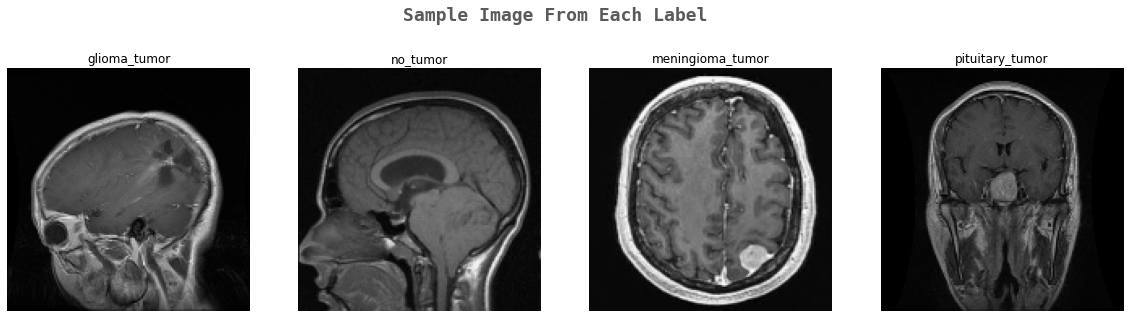

In [5]:
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import ELU
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join 
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16

In [30]:
train_data_dir = "brain_tumor/Training"
validation_data_dir = "brain_tumor/Testing"

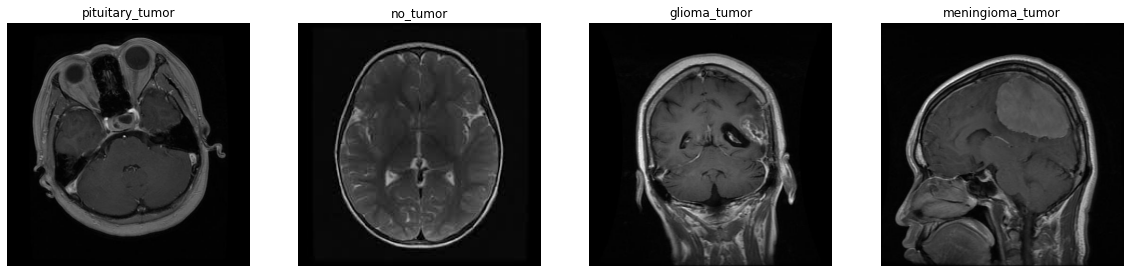

In [ ]:
# Question 1 (Visualize samples)

# Plot images
fig = plt.figure(figsize=(20,80))
subplot_idx = 1
for folder in os.listdir(train_data_dir):
  img = mpimg.imread(os.path.join(train_data_dir, folder, os.listdir(os.path.join(train_data_dir, folder))[7]))
  ax = fig.add_subplot(1,4,subplot_idx)
  ax.imshow(img)
  ax.axis("off")
  plt.title(folder)
  subplot_idx += 1

**Question 2**  
Complete the preprocessing/augmentation process (10 points)  
*Try different augmentation operation: Rotate, flip, shift, etc.*  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [31]:
# Question 2
train_datagen = ImageDataGenerator(
    ## Fill the following lines
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6,1.4],
    fill_mode="nearest"
)

In [32]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2870 images belonging to 4 classes.


In [34]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 394 images belonging to 4 classes.


**Question 3**  
Implement a simple 5-conv-layer CNN (40 points)   
https://www.tensorflow.org/api_docs/python/tf/keras/Input   
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D    
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

*Following the structure in the plot below:*

Model structure:  
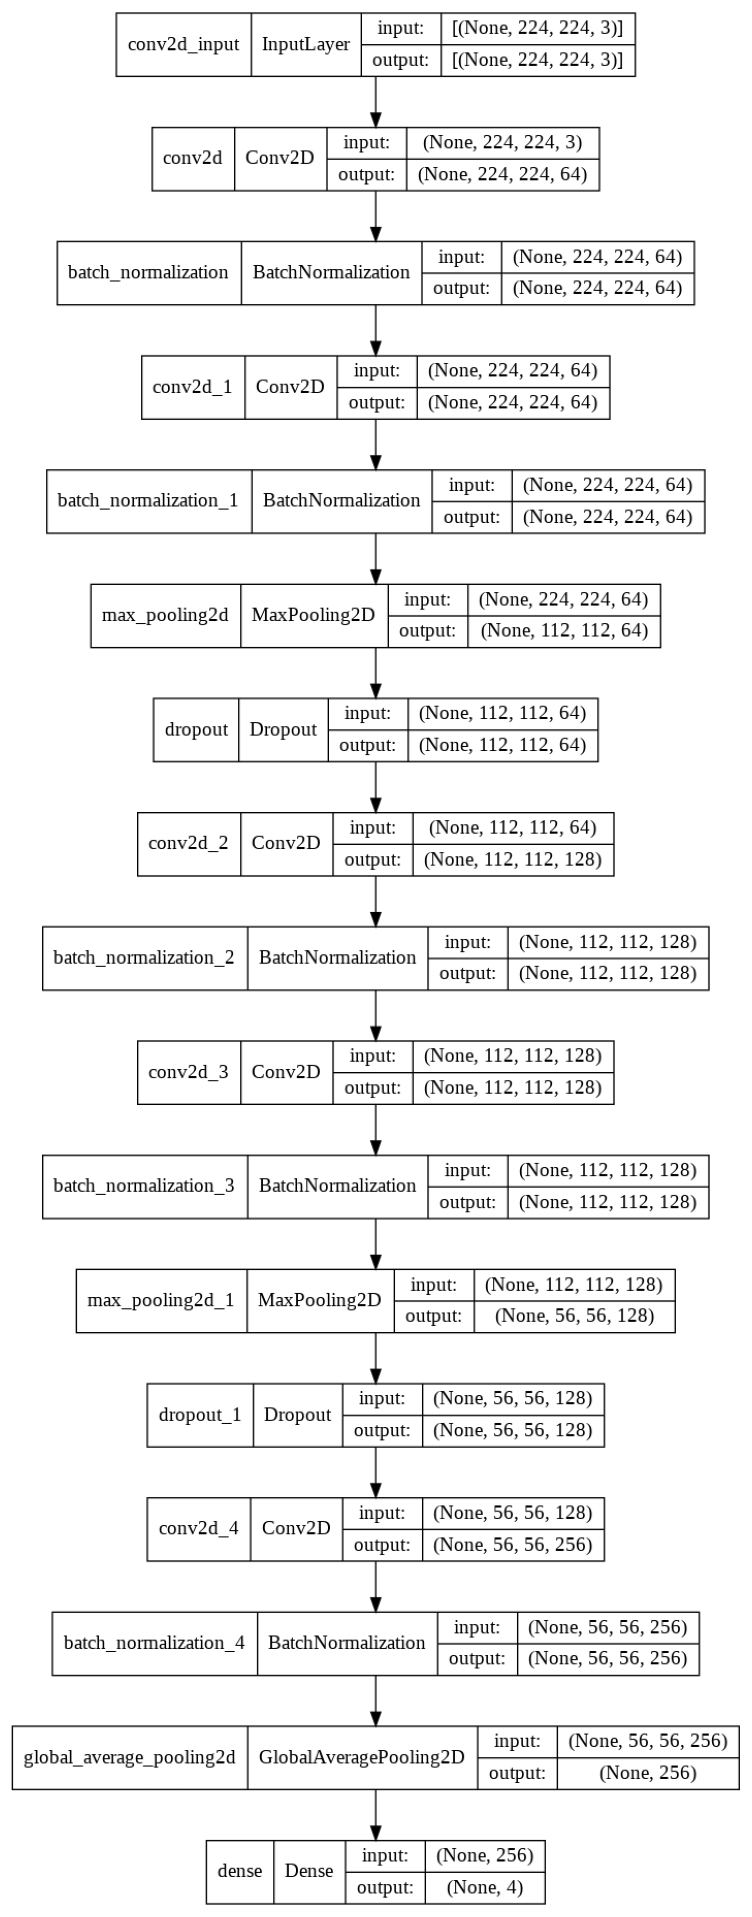

Hint: The convolutional kernal size are all set to be (3, 3), stride is (1, 1), padding is "same". Set other parameters as reasonable numbers.

In [ ]:
# Question 3
def cnn():
    model = tf.keras.models.Sequential([

    # 1st CONV-ReLU Layer
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu', padding="same"),
    BatchNormalization(),

    # 2nd CONV-ReLU Layer
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout
    MaxPool2D(),
    Dropout(rate=0.3),

    # 3rd set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    # 4th Set of CONV-ReLU Layers
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    # Max Pooling with Dropout 
    MaxPool2D(),
    Dropout(rate=0.3),

    # 5th Set of CONV-ReLU Layers
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
        
    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Final Dense Layer
    Dense(num_classes)

    ])
    return model

In [ ]:
# Check if you got a similar model summary
model = cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

**Train CNN Model**

In [ ]:
checkpoint_path = "train_ckpt/cp-{epoch:04d}.ckpt"

In [ ]:
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.3, 
    patience=2,
    min_delta=0.001,
    mode='auto',verbose=1)

callbacks=[checkpoint]

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [12]:
nb_train_samples = 2870
nb_validation_samples = 394
epochs = 20

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
179/179 [==============================] - ETA: 0s - loss: 3.0706 - accuracy: 0.1811
Epoch 1: val_loss improved from inf to 5.04668, saving model to train_ckpt/cp-0001.ckpt
INFO:tensorflow:Assets written to: train_ckpt/cp-0001.ckpt/assets
179/179 [==============================] - 98s 497ms/step - loss: 3.0706 - accuracy: 0.1811 - val_loss: 5.0467 - val_accuracy: 0.2682
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 1.9331 - accuracy: 0.2256
Epoch 2: val_loss improved from 5.04668 to 1.75370, saving model to train_ckpt/cp-0002.ckpt
INFO:tensorflow:Assets written to: train_ckpt/cp-0002.ckpt/assets
179/179 [==============================] - 77s 428ms/step - loss: 1.9331 - accuracy: 0.2256 - val_loss: 1.7537 - val_accuracy: 0.3932
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 1.6613 - accuracy: 0.1952
Epoch 3: val_loss did not improve from 1.75370
179/179 [==============================] - 74s 411ms/step - loss: 1.6613 - accuracy: 

In [ ]:
# Save your model
!mkdir -p saved_model
model.save('saved_model/CNN5_model') 

INFO:tensorflow:Assets written to: saved_model/CNN5_model/assets


**Question 4**  
Visulaize the training and validation history  
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

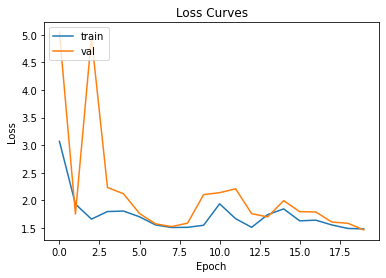

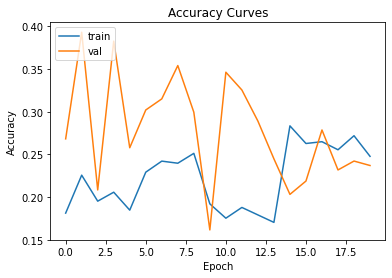

In [ ]:
# Question 4

#Loss Curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Accuracy Curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Question 5**  
Plot the confusion matrix (15 points)

In [13]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [ ]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)

# Question 5
## Fill the line below
y_pred_label = y_pred.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


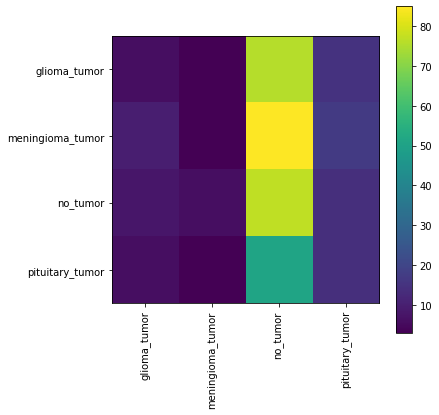

In [ ]:
plt.figure(figsize=(6,6))
# Question 5
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.20      0.06      0.09       100
meningioma_tumor       0.20      0.03      0.05       115
        no_tumor       0.27      0.73      0.39       105
 pituitary_tumor       0.23      0.19      0.21        74

        accuracy                           0.25       394
       macro avg       0.22      0.25      0.18       394
    weighted avg       0.22      0.25      0.18       394



**Question 6**  
Analyze and expalin the performance of your model (15 points)  
*How is your training and validation curve? What does this indicate. How can you improve the performance of this model?*

**Answer**  
The performance of my model is not satisfactory. Looking at the loss curves, even though it is more evident for the training than for the validation one, we can observe a decreasing trend for both curves. This indicates that the model is learning. However, considering that the rate of this decreasing trend seems to be very small, and that after epoch 20 the curves seem to reach a plateau, we can deduce that the model is not learning much. When examining the accuracy curves, it is more difficult to identify a trend. We should see an increasing trend for the validation and training curves, but it is not clear from this plot, which indicates a poor performance because the model is not learning. Another indicator of the unsatisfactory performance is the confusion matrix. It is easy to see that the majority of the validation samples are being classified as "no tumor".  
Perhaps, to enhance the performance of this model, we could obtain a better dataset in which all the classes are balanced. We could also create a better preprocessing pipeline for the dataset, and shuffle the data. Another option could be to play with the hyperparameters of the model to try to obtain better results. We could also try to implement a deeper model by increasing the number of convolutional layers; however, considering the size of the dataset, this could result in overfitting. The last alternative we could try is the use of transfer learning with pretrained models, trained on large datasets, such as ImageNet.

**Question 7**  
Implement a deeper model by transfer learning (Bonus 5 points)  
https://www.tensorflow.org/api_docs/python/tf/keras/applications  

If you are interestedin this topic, take a look at:  
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

In [35]:
from tensorflow.keras.applications import ResNet50
from keras.layers import Input

In [36]:
def pretrained_resnet():

  pretrained_model = Sequential()

  input_tensor = Input(shape=(224, 224, 3))
  resnet_model = ResNet50(include_top=False, weights='imagenet', pooling="avg")
  for layer in resnet_model.layers:
    layer.trainable = False

  pretrained_model.add(resnet_model)
  pretrained_model.add(Dense(num_classes))

  return pretrained_model

In [37]:
model = pretrained_resnet()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [39]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
179/179 [==============================] - 63s 331ms/step - loss: 6.9193 - accuracy: 0.2873 - val_loss: 7.3035 - val_accuracy: 0.2917
Epoch 2/20
179/179 [==============================] - 56s 315ms/step - loss: 6.8674 - accuracy: 0.2863 - val_loss: 7.3455 - val_accuracy: 0.2943
Epoch 3/20
179/179 [==============================] - 56s 314ms/step - loss: 6.8335 - accuracy: 0.2870 - val_loss: 7.3455 - val_accuracy: 0.2943
Epoch 4/20
179/179 [==============================] - 57s 315ms/step - loss: 6.8392 - accuracy: 0.2863 - val_loss: 7.3455 - val_accuracy: 0.2943
Epoch 5/20
179/179 [==============================] - 61s 341ms/step - loss: 6.8392 - accuracy: 0.2870 - val_loss: 7.3455 - val_accuracy: 0.2943
Epoch 6/20
179/179 [==============================] - 59s 328ms/step - loss: 6.8618 - accuracy: 0.2863 - val_loss: 7.2615 - val_accuracy: 0.2917
Epoch 7/20
179/179 [==============================] - 60s 335ms/step - loss: 6.8618 - accuracy: 0.2863 - val_loss: 7.3875 - val_ac

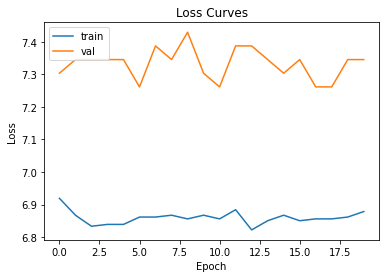

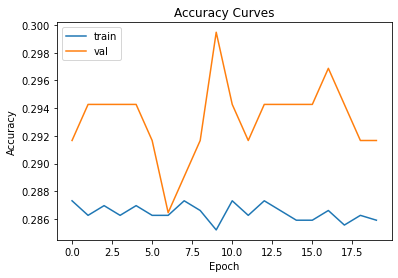

In [40]:
#Loss Curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Accuracy Curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = y_pred.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


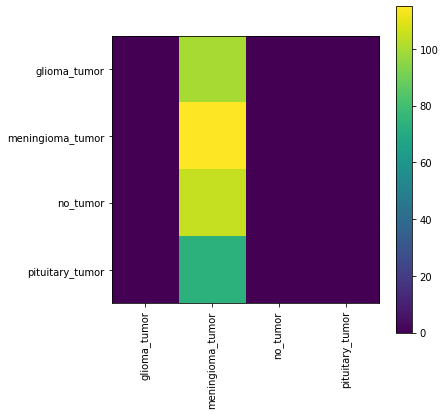

In [42]:
plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [43]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.29      1.00      0.45       115
        no_tumor       0.00      0.00      0.00       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.29       394
       macro avg       0.07      0.25      0.11       394
    weighted avg       0.09      0.29      0.13       394



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
